In [15]:
using BPTT
using Distributions, DSP, Plots, NPZ, FFTW
using LombScargle, Deconvolution, Statistics


In [16]:
t = range(0, stop=10, length=1000) # observation times
x = sinpi.(t) .* cos.(5t) - 1.5cospi.(t) .* sin.(2t) # the original signal
n = rand(length(x)) # noise to be added
y = x + 3(n .- mean(n)) # observed noisy signal

1000-element Vector{Float64}:
  0.3570097840005136
 -0.42425419749815063
  1.21240612980455
 -0.450563476062537
 -1.100828215870636
  0.5239483506583414
 -1.1395872746545512
  1.2672549065276073
 -1.2185124288289586
  0.34702489318389124
 -1.318248116719518
 -0.5871643040510574
 -1.3165363677300184
  ⋮
 -1.0927509598527392
 -0.2703541193897858
 -1.9945831456821481
 -0.985103467148063
 -2.6576875022929483
  0.045099730110341296
 -2.717868360448729
 -1.4048690253033598
 -1.1477521859123845
 -0.812507615649015
 -1.704093299284807
 -0.3191703456853012

In [34]:
function spm_Gpdf(x, α, β)
    k = α
    Θ = 1/β
    dist = Gamma(α,Θ)
    return pdf.(dist, x)
end

function spm_hrf(RT)
    p = [6., 16., 1., 1., 6., 0., 32.]
    fMRI_T=16
    
    dt = RT / fMRI_T
    u = (range(0, ceil(Int64,p[7]/dt), step=1) |> collect) .- (p[6]/dt)
    
    hrf = spm_Gpdf(u, p[1]/p[3], dt/p[3]) - spm_Gpdf(u, p[2]/p[4], dt/p[4])/p[5]
    print(range(0, floor(Int64,p[7]/RT)))
    hrf = hrf[range(0, floor(Int64,p[7]/RT))*fMRI_T .+ 1]
    return hrf/sum(hrf)
end

spm_hrf (generic function with 1 method)

(1000,)
(1000,)
0:26

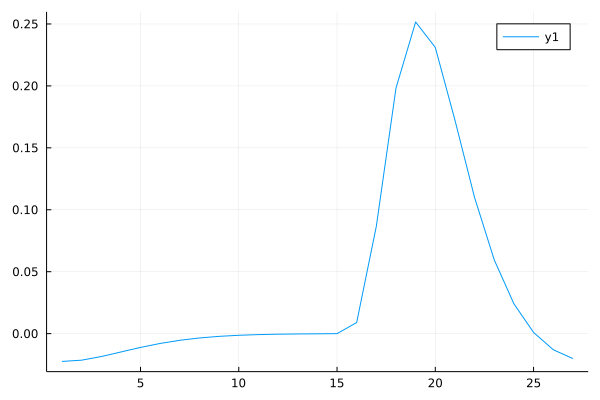

In [40]:
# Gaussian blurring kernel
kernel = exp.( - 10 .* (t .- 5).^2)
kernel ./= sum(kernel) # normalize kernel to sum of 1
println(size(kernel))
println(size(signal))

kernel = spm_hrf(1.2)

kernel = ifftshift(kernel) # move center to index pos 1
plot(kernel)



In [37]:
p = lombscargle(t, y, maximum_frequency=2, samples_per_peak=10)

m1 = LombScargle.model(t, y, findmaxfreq(p, [0, 0.5])[1]) # first model
m2 = LombScargle.model(t, y, findmaxfreq(p, [0.5, 1])[1]) # second model
m3 = LombScargle.model(t, y, findmaxfreq(p, [1, 1.5])[1]) # third model

1000-element Vector{Float64}:
 -0.006889664210832279
  0.038268070217702024
  0.08336081861332365
  0.12808960595740776
  0.17215787037459612
  0.21527342940443417
  0.25715041723650667
  0.2975111800647693
  0.3360881169944523
  0.3726254542959119
  0.4068809412417281
  0.4386274562832702
  0.4676545129174194
  ⋮
 -0.5019914525672045
 -0.4870281781255078
 -0.46864705797060663
 -0.44696996304485953
 -0.4221406173413699
 -0.39432364498171235
 -0.3637034787211573
 -0.3304831371182038
 -0.29488287847607386
 -0.25713874048086377
 -0.21750097521880418
 -0.17623238994891366

In [38]:
signal = m1 + m2 + m3 # signal for `wiener`
noise = rand(length(y)) # noise for `wiener`

y_blurred = real(ifft(fft(kernel) .* fft(x))) + noise
deblurred = wiener(y_blurred, signal, noise, kernel)

plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, deblurred, label="Deblurred with Wiener")

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 27 and 1000")

In [54]:
using Images, TestImages, Deconvolution, FFTW, ZernikePolynomials, ImageView

img = channelview(testimage("cameraman"))

# model of lens aberration
blurring = evaluateZernike(LinRange(-16,16,512), [12, 4, 0], [1.0, -1.0, 2.0], index=:OSA)
blurring = fftshift(blurring)
blurring = blurring ./ sum(blurring)

blurred_img = fft(img) .* fft(blurring) |> ifft |> real

@time restored_img = lucy(blurred_img, blurring, iterations=1000)

imshow(img)
imshow(blurring)
imshow(blurred_img)
imshow(restored_img)

┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1423
ERROR: LoadError: InitError: Cannot open display: 
Stacktrace:
  [1] error(s::String)
    @ Base ./error.jl:33
  [2] Gtk.GLib.GError(f::Gtk.var"#329#338")
    @ Gtk.GLib ~/.julia/packages/Gtk/OyCvN/src/GLib/gerror.jl:17
  [3] __init__()
    @ Gtk ~/.julia/packages/Gtk/OyCvN/src/Gtk.jl:158
  [4] _include_from_serialized(path::String, depmods::Vector{Any})
    @ Base ./loading.jl:768
  [5] _require_search_from_serialized(pkg::Base.PkgId, sourcepath::String)
    @ Base ./loading.jl:854
  [6] _require(pkg::Base.PkgId)
    @ Base ./loading.jl:1097
  [7] require(uuidkey::Base.PkgId)
    @ Base ./loading.jl:1013
  [8] require(into::Module, mod::Symbol)
    @ Base ./loading.jl:997
  [9] include
    @ ./Base.jl:418 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Ba

LoadError: Failed to precompile ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef] to /home/eric/.julia/compiled/v1.7/ImageView/jl_RXiz24.

In [53]:
import Pkg; Pkg.precompile("ImageView")

LoadError: MethodError: no method matching precompile(::String)
[0mClosest candidates are:
[0m  precompile(; kwargs...) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/Pkg/src/API.jl:1011
[0m  precompile([91m::Pkg.Types.Context[39m; internal_call, strict, warn_loaded, already_instantiated, kwargs...) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/Pkg/src/API.jl:1012